In [8]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import Adamax

import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from skimage.segmentation._quickshift import quickshift

import cv2

import shutil
from tqdm import tqdm
import albumentations as A
import copy

In [9]:
root_path = "d:/ham/"

df_path = root_path + "ham_work_folder/test_df.csv"
df = pd.read_csv(df_path)

In [10]:
# Rename the columns
new_column_names = {'path': 'filepaths', 'cell_type_idx': 'labels'}
df = df.rename(columns=new_column_names)
df["labels"] = df['labels'].apply(lambda x: str(x))
df["filepaths"] = df["filepaths"].str.replace("gdrive/MyDrive/", root_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  1002 non-null   int64  
 1   Unnamed: 0    1002 non-null   int64  
 2   lesion_id     1002 non-null   object 
 3   image_id      1002 non-null   object 
 4   dx            1002 non-null   object 
 5   dx_type       1002 non-null   object 
 6   age           991 non-null    float64
 7   sex           1002 non-null   object 
 8   localization  1002 non-null   object 
 9   filepaths     1002 non-null   object 
 10  cell_type     1002 non-null   object 
 11  labels        1002 non-null   object 
 12  ita           1002 non-null   float64
 13  fts           1002 non-null   int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 109.7+ KB


In [11]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (310,640)
batch_size=16
ycol='labels'

trgen=ImageDataGenerator(horizontal_flip=True)
t_and_v_gen=ImageDataGenerator()

def make_test_generator(xcol):
    length=len(df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    #print(length)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(df, x_col=xcol, y_col=ycol, target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    return test_gen

test_gen = make_test_generator("filepaths")

Found 1002 validated image filenames belonging to 7 classes.           for test generator 


In [12]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [14]:
# model load
model_path = root_path + "ham_work_folder/saved_model/"
model = tf.keras.models.load_model(model_path, custom_objects={'F1_score': F1_score})

# Needs to compile again as for lr setting
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 310, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 310, 640, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 310, 640, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 310, 640, 3)          0         ['normalization[0][0]'

In [15]:
# To check
model.layers[-1].get_weights()[0]

array([[ 0.05559245, -0.18024282,  0.12250493, ..., -0.0295473 ,
        -0.17020807, -0.15949364],
       [-0.12429732, -0.23267792, -0.21331936, ...,  0.23716791,
         0.23557101, -0.042546  ],
       [ 0.05453651, -0.10753678,  0.13634595, ...,  0.07818402,
        -0.02538554,  0.02428198],
       ...,
       [-0.1847724 , -0.11073647,  0.55943775, ...,  0.05239721,
        -0.440774  , -0.46829966],
       [-0.23853803,  0.51700175, -0.27631506, ..., -0.24088919,
        -0.31163523, -0.02179029],
       [-0.332065  , -0.34693554, -0.32986775, ..., -0.3523678 ,
        -0.49162748,  0.6808193 ]], dtype=float32)

In [16]:
def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true, clr

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true, clr = predictor(test_gen)

167/167 [==============================] - 156s 903ms/step
there were 162 errors in 1002 tests for an accuracy of  83.83



In [17]:
df["predictions"] = y_pred

In [18]:
def mark_boundaries_custom(image, labels):
    boundaries = np.gradient(labels)
    boundary_mask = np.logical_or(boundaries[0] != 0, boundaries[1] != 0)
    marked_image = image.copy()
    marked_image[boundary_mask] = [1, 0, 0]  # Red color for boundaries
    return marked_image

In [19]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

In [20]:
def create_heat_mask(superpixels_b, coeff):
    # Initialize an empty image
    heat_mask = np.zeros_like(superpixels_b, dtype=float)

    # Iterate over the unique labels of the superpixels
    for idx, label in enumerate(np.unique(superpixels_b)):
        # Set the pixels of the current superpixel to its corresponding coefficient
        heat_mask[superpixels_b == label] = coeff[idx]

    return heat_mask

In [21]:
# Compute percentage of true label covered by the exmplainer
def get_coverage(input_im, mask, coi):
    tot = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if sum(input_im[i,j]) > 0:
                if mask[i,j] == coi:
                    tot += 1
                else:
                    tot -= 1
    cov = tot/np.count_nonzero(mask==coi)
    return cov

In [22]:
# Compute weighted percentage of true label covered by the exmplainer
def get_weighted_coverage(input_im, mask, coi):
    # coi : Class of interest, here default is set to dog
    copy_mask = np.copy(mask).astype('float')
    np.place(copy_mask, copy_mask==0, -1)
    np.place(copy_mask, copy_mask==2, -1)
    tot = 0
    for i in range(copy_mask.shape[0]):
        for j in range(copy_mask.shape[1]):
            tot += input_im[i,j] * copy_mask[i,j]
    w_cov = tot/(copy_mask.shape[0]*copy_mask.shape[1])
    return w_cov

In [23]:
def Wasserstein_Dist(XX, YY):

    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;

    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap:
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger

    pVal = bigger/nboots;

    return pVal, WD

def Wasserstein_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        print('input images should have the same size')
    else:
        WD = []
        for ii in range(3):

            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            WD.append(Wasserstein_Dist(im1, im2))

    return sum(WD)

def xwhy_image_wd(X_input, model, top_pred_classes, num_perturb = 1000, kernel_width = 0.25, eps = 0.01):

    superpixels = quickshift(X_input, kernel_size=10, max_dist=200, ratio=0.5)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))


    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image

    predictions = []
    WD_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:], verbose=0)
        predictions.append(pred)
        WD_dist = Wasserstein_Dist_Image(X_input, perturbed_img) + eps


    predictions = np.array(predictions)

    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

    weights = np.sqrt(np.exp(-((WD_dist+distances)**2)/kernel_width**2)) #Kernel function

    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]

    return coeff, superpixels, num_superpixels

In [32]:
def SMILE_explainability(index, df_index, gen):
    Xi, _ = gen[index]
    if len(Xi.shape) == 4:
        Xi = Xi[0]
    if Xi.shape[-1] == 3:  # Check if it's a color image
        Xi = cv2.cvtColor(Xi, cv2.COLOR_BGR2RGB)
    #Xi = cv2.resize(Xi, (299, 299))
    Xi = (Xi / 255.0 - 0.5) * 2
    #plt.imshow(Xi[:, :, ::-1] / 2 + 0.5)
    #plt.axis('off')  # Hide axes
    #plt.show()

    sample, _ = gen[index]
    preds = model.predict(sample)
    top_pred_classes = preds[0].argsort()

    coeff_wd, superpixels_wd, num_superpixels  = xwhy_image_wd(Xi, model, top_pred_classes, num_perturb = 1000, kernel_width = 0.25)

    num_top_features = 4
    top_features = np.argsort(coeff_wd)[-num_top_features:]
    mask = np.zeros(num_superpixels)
    mask[top_features]= True #Activate top superpixels
    skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels_wd))

    heat_mask_XWhy = create_heat_mask(superpixels_wd, coeff_wd)
    #plt.imshow(heat_mask_XWhy, cmap='plasma', interpolation='nearest')
    #plt.colorbar()
    #plt.title('Heatmap of SMILE Coeffs - WD')
    #plt.show()

    image_id = df.iloc[df_index]["image_id"]
    act_label = int(df.iloc[df_index]["labels"])
    img_path = df.iloc[df_index]["filepaths"]
    seg_path = "d:/ham/ham_segmentation/{}_segmentation.png".format(image_id)
    seg_img = cv2.imread(seg_path)

    # Check if the image is loaded successfully
    if seg_img is None:
        print(f"Error: Unable to read the image from {seg_path}")
    else:
        # Define the target colors
        bg_color = (128, 128, 128)
        abnormal_color = (0, 255, 200)

        # Create a mask for background pixels
        bg_mask = np.all(seg_img == [0, 0, 0], axis=-1)
        # Apply the background color to the background pixels
        seg_img[bg_mask] = bg_color
        # Create a mask for abnormal pixels
        abnormal_mask = ~bg_mask
        # Apply the abnormal color to the abnormal pixels
        seg_img[abnormal_mask] = abnormal_color

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    #axes[0].imshow(seg_img)
    #axes[1].imshow(img)
    #plt.show()

    # Check if the image is loaded successfully
    if seg_img is not None:
        height, width, _ = seg_img.shape
        sem_mask = np.full((height, width), 0)
        sem_mask[bg_mask] = 9
        sem_mask[abnormal_mask] = act_label
        seman_transformed = skimage.transform.resize(sem_mask, (299,299), preserve_range=True).astype('uint8')

    a = perturb_image(Xi/2+0.5,mask,superpixels_wd)
    cov = get_coverage(a, seman_transformed, act_label)
    print("The coverage with the true label is : ", cov)

    w_cov = get_weighted_coverage(heat_mask_XWhy, seman_transformed, act_label)
    print("The weighted coverage of the heatmap with the true label is : ", w_cov)

    return (cov, w_cov)

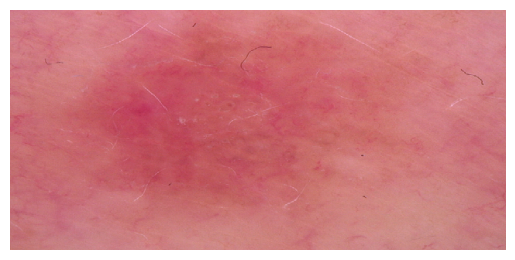

1/1 [==============================] - 1s 977ms/step


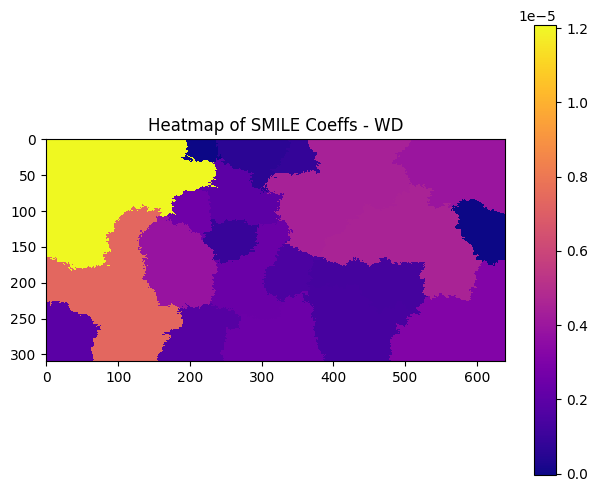

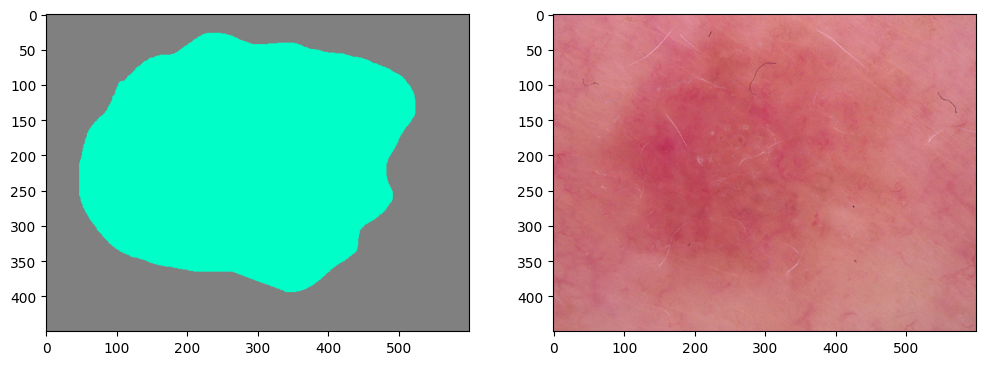

The coverage with the true label is :  0.16048656533810174
The weighted coverage of the heatmap with the true label is :  2.148770692264837e-05


In [29]:
index = 11
df_index = index * 6

cov = SMILE_explainability(index, df_index, test_gen)

In [30]:
cov

(0.16048656533810174, 2.148770692264837e-05)

In [31]:
len(test_gen)

167

1/1 [==============================] - 1s 945ms/step
The coverage with the true label is :  -3.476375317895864
The weighted coverage of the heatmap with the true label is :  6.658557466225847e-06
1/1 [==============================] - 1s 987ms/step
The coverage with the true label is :  -1.5413186813186812
The weighted coverage of the heatmap with the true label is :  3.1084983152604308e-06
1/1 [==============================] - 1s 973ms/step
The coverage with the true label is :  -0.7840573597638127
The weighted coverage of the heatmap with the true label is :  -4.224639897065508e-05
1/1 [==============================] - 1s 1000ms/step
The coverage with the true label is :  -11.588665447897624
The weighted coverage of the heatmap with the true label is :  2.4777378543380224e-06
1/1 [==============================] - 1s 1s/step
The coverage with the true label is :  -0.1384975118412375
The weighted coverage of the heatmap with the true label is :  2.5177916782265567e-06
1/1 [=========

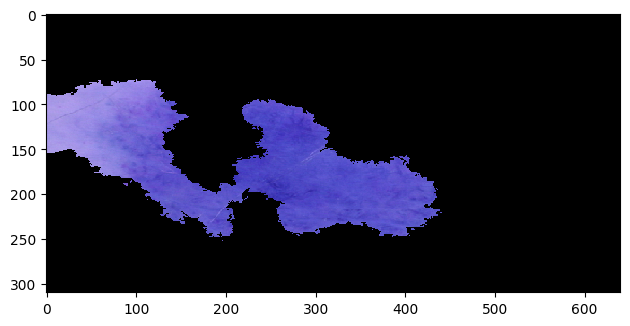

In [33]:
ce = []
for index in range(100):
    df_index = index * 6
    cov = SMILE_explainability(index, df_index, test_gen)
    ce.append(cov)

In [34]:
len(ce)

100

In [35]:
ce[0]

(-3.476375317895864, 6.658557466225847e-06)

In [36]:
exp_index = [index * 6 for index in range(100)]
df_explained = df.iloc[exp_index].copy()

covs = [c[0] for c in ce]
w_covs = [c[1] for c in ce]

df_explained["cov"] = covs
df_explained["w_cov"] = w_covs

In [37]:
df_explained

,Unnamed: 0.1,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,fts,predictions,cov,w_cov
0,1156,1156,HAM_0000827,ISIC_0031443,df,consensus,60.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0031443...,Dermatofibroma,6,72.229988,1,6,-3.476375,6.658557e-06
6,1242,1242,HAM_0003558,ISIC_0025303,mel,histo,55.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0025303...,dermatofibroma,1,111.794889,1,1,-1.541319,3.108498e-06
12,2242,2242,HAM_0004898,ISIC_0024932,mel,histo,55.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0024932...,dermatofibroma,1,82.010431,1,1,-0.784057,-4.224640e-05
18,1344,1344,HAM_0004265,ISIC_0026296,mel,histo,45.0,male,unknown,d:/ham/ham/HAM10000_images_part_1/ISIC_0026296...,dermatofibroma,1,115.822368,1,1,-11.588665,2.477738e-06
24,2772,2772,HAM_0006708,ISIC_0027189,bcc,histo,80.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0027189...,Basal cell carcinoma,3,108.574231,1,3,-0.138498,2.517792e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,9418,9418,HAM_0003539,ISIC_0025897,nv,consensus,75.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0025897...,Melanocytic nevi,0,84.791867,1,0,-0.416175,-1.907510e-05
576,7147,7147,HAM_0002616,ISIC_0034254,nv,histo,55.0,female,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0034254...,Melanocytic nevi,0,114.283933,1,4,0.293156,9.719519e-06
582,3199,3199,HAM_0007050,ISIC_0027160,nv,follow_up,45.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0027160...,Melanocytic nevi,0,62.658895,1,0,-1.265051,4.719496e-07
588,68,68,HAM_0004641,ISIC_0031485,bkl,histo,60.0,male,abdomen,d:/ham/ham/HAM10000_images_part_2/ISIC_0031485...,Benign keratosis-like lesions,2,124.578429,1,2,-3.281613,6.043001e-07


Text(0.5, 0, 'ITA')

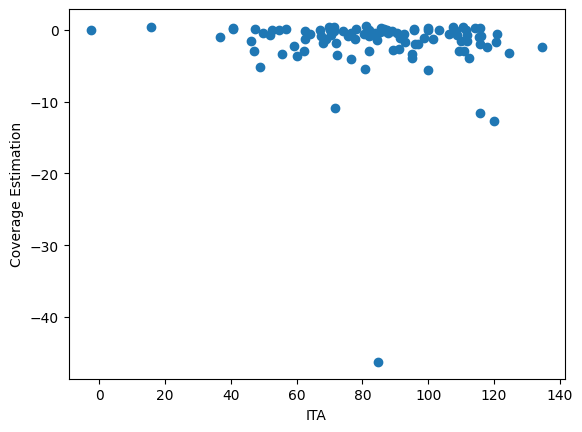

In [38]:
plt.scatter(df_explained["ita"], df_explained["cov"])
plt.ylabel("Coverage Estimation")
plt.xlabel("ITA")

Text(0.5, 0, 'ITA')

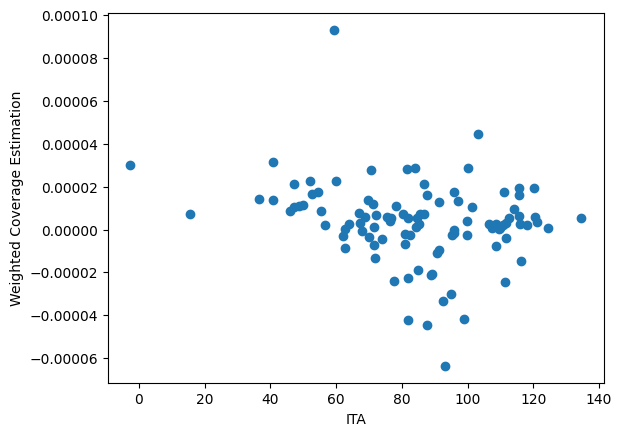

In [39]:
plt.scatter(df_explained["ita"], df_explained["w_cov"])
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("ITA")

In [40]:
df_explained.to_csv("d:/ham/working/SMILE.csv", index=False)

In [41]:
rgb_path = "d:/ham/ham_work_folder/df_with_fst_RGB.csv"
df_rgb = pd.read_csv(rgb_path)
df_rgb = df_rgb[["image_id", "R", "G", "B"]]

In [42]:
df_explained = df_explained.merge(df_rgb, how="left", on="image_id") 

In [43]:
df_explained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  100 non-null    int64  
 1   Unnamed: 0    100 non-null    int64  
 2   lesion_id     100 non-null    object 
 3   image_id      100 non-null    object 
 4   dx            100 non-null    object 
 5   dx_type       100 non-null    object 
 6   age           99 non-null     float64
 7   sex           100 non-null    object 
 8   localization  100 non-null    object 
 9   filepaths     100 non-null    object 
 10  cell_type     100 non-null    object 
 11  labels        100 non-null    object 
 12  ita           100 non-null    float64
 13  fts           100 non-null    int64  
 14  predictions   100 non-null    int64  
 15  cov           100 non-null    float64
 16  w_cov         100 non-null    float64
 17  R             100 non-null    float64
 18  G             100 non-null    f

# Correlation between coverage estimation and color-channels

## R-channel

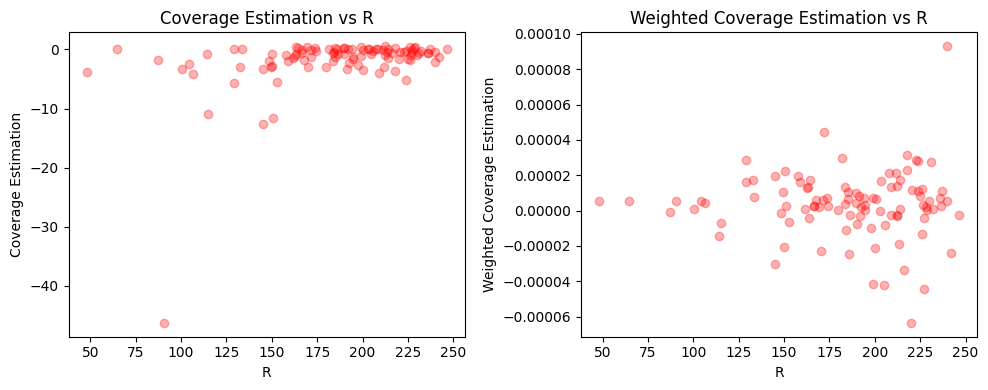

In [44]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(df_explained["R"], df_explained["cov"], color="r", alpha=0.3)
plt.ylabel("Coverage Estimation")
plt.xlabel("R")
plt.title("Coverage Estimation vs R")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(df_explained["R"], df_explained["w_cov"], color="r", alpha=0.3)
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("R")
plt.title("Weighted Coverage Estimation vs R")

plt.tight_layout()
plt.show()

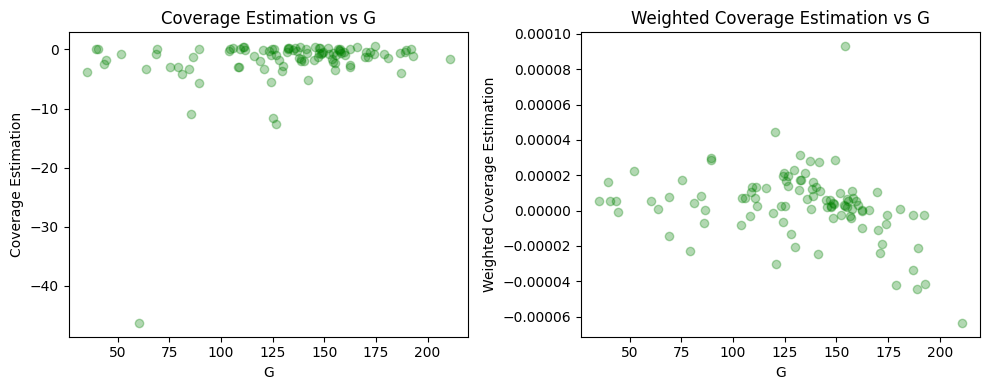

In [45]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(df_explained["G"], df_explained["cov"], color="g", alpha=0.3)
plt.ylabel("Coverage Estimation")
plt.xlabel("G")
plt.title("Coverage Estimation vs G")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(df_explained["G"], df_explained["w_cov"], color="g", alpha=0.3)
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("G")
plt.title("Weighted Coverage Estimation vs G")

plt.tight_layout()
plt.show()

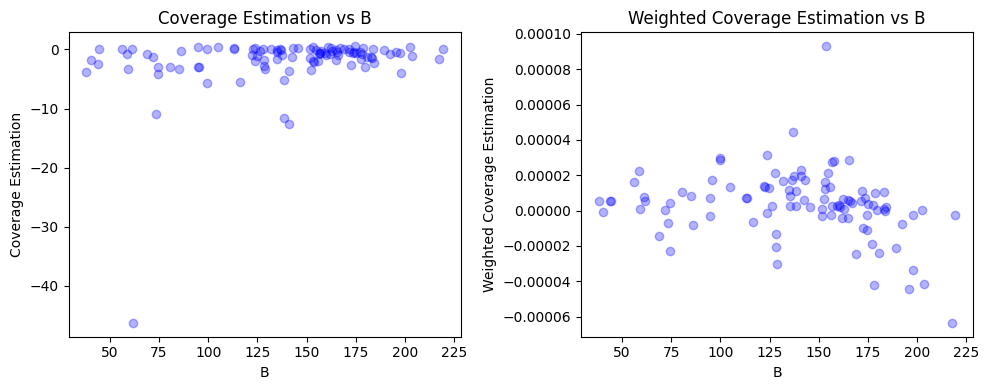

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(df_explained["B"], df_explained["cov"], color="b", alpha=0.3)
plt.ylabel("Coverage Estimation")
plt.xlabel("B")
plt.title("Coverage Estimation vs B")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(df_explained["B"], df_explained["w_cov"], color="b", alpha=0.3)
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("B")
plt.title("Weighted Coverage Estimation vs B")

plt.tight_layout()
plt.show()

In [47]:
# Baseline
color_space = "RGB"
c_channel = "R"
bl = df_explained[c_channel].max()

In [48]:
baseline = df_explained[round(df_explained[c_channel]) == round(bl)].sample(n=1, random_state=12)
baseline

,Unnamed: 0.1,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,fts,predictions,cov,w_cov,R,G,B
91,8330,8330,HAM_0005110,ISIC_0028494,nv,histo,20.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0028494...,Melanocytic nevi,0,99.936507,1,0,0.03423,-0.000003,246.641264,192.193037,219.491365


In [49]:
color_space_mappings = {
    "RGB": cv2.COLOR_BGR2RGB, "HSV": cv2.COLOR_BGR2HSV, "LAB": cv2.COLOR_BGR2LAB, "YCrCb": cv2.COLOR_BGR2YCrCb}

In [50]:
# Baseline color distribution
base_channels = extract_skin_pixels(baseline["filepaths"].values[0])

NameError: name 'extract_skin_pixels' is not defined

In [ ]:
# Wasserstein distance
w_distances = []
for s in df_explained["filepaths"]:
    c = extract_skin_pixels(s)
    w_dis = Wasserstein_Dist(base_channels, c)
    w_distances.append(w_dis)
df_explained["wasserstein"] = w_distances

In [ ]:
# Kuiper_Dist
distances = []
for s in df_explained["filepaths"]:
    c = extract_skin_pixels(s)
    dis = Kuiper_Dist(base_channels, c)
    distances.append(dis)
df_explained["kuiper"] = distances

In [ ]:
# Anderson_Darling_Dist
distances = []
for s in df_explained["filepaths"]:
    c = extract_skin_pixels(s)
    dis = Anderson_Darling_Dist(base_channels, c)
    distances.append(dis)
df_explained["anderson"] = distances

In [ ]:
# Cramer-Von Mises Distance
distances = []
for s in df_explained["filepaths"]:
    c = extract_skin_pixels(s)
    dis = CVM_Dist(base_channels, c)
    distances.append(dis)
df_explained["cvm"] = distances

In [ ]:
# Kolmogorov_Smirnov_Dist
distances = []
for s in df_explained["filepaths"]:
    c = extract_skin_pixels(s)
    dis = Kolmogorov_Smirnov_Dist(base_channels, c)
    distances.append(dis)
df_explained["kolmogorov"] = distances

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(df_explained["wasserstein"], df_explained["cov"], alpha=0.2)
plt.scatter(df_explained["kuiper"], df_explained["cov"], alpha=0.2)
plt.scatter(df_explained["anderson"], df_explained["cov"], alpha=0.2)
plt.scatter(df_explained["cvm"], df_explained["cov"], alpha=0.2)
plt.scatter(df_explained["kolmogorov"], df_explained["cov"], alpha=0.2)
plt.ylabel("Coverage Estimation")
plt.xlabel("Distance")
plt.title("Coverage Estimation vs wasserstein")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(df_explained["wasserstein"], df_explained["w_cov"], alpha=0.2)
plt.scatter(df_explained["kuiper"], df_explained["w_cov"], alpha=0.2)
plt.scatter(df_explained["anderson"], df_explained["w_cov"], alpha=0.2)
plt.scatter(df_explained["cvm"], df_explained["w_cov"], alpha=0.2)
plt.scatter(df_explained["kolmogorov"], df_explained["w_cov"], alpha=0.2)
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("Distance")
plt.title("Weighted Coverage Estimation vs wasserstein")

plt.tight_layout()
plt.show()

In [ ]:
cov = baseline["cov"]
dif_cov = []
for s in df_explained["cov"]:
    dif_cov.append(cov - s)

In [ ]:
w_cov = baseline["cov"]
dif_w_cov = []
for s in df_explained["w_cov"]:
    dif_w_cov.append(w_cov - s)

In [ ]:
df_explained["dif cov"] = dif_cov
df_explained["dif w_cov"] = dif_w_cov

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(df_explained["wasserstein"], df_explained["dif cov"], alpha=0.2)
#plt.scatter(df_explained["kuiper"], df_explained["dif cov"], alpha=0.2)
#plt.scatter(df_explained["anderson"], df_explained["dif cov"], alpha=0.2)
plt.scatter(df_explained["cvm"], df_explained["dif cov"], alpha=0.2)
#plt.scatter(df_explained["kolmogorov"], df_explained["dif cov"], alpha=0.2)
plt.ylabel("Coverage Estimation")
plt.xlabel("Distance")
plt.title("Coverage Estimation vs distances")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(df_explained["wasserstein"], df_explained["dif w_cov"], alpha=0.2)
#plt.scatter(df_explained["kuiper"], df_explained["dif w_cov"], alpha=0.2)
#plt.scatter(df_explained["anderson"], df_explained["dif w_cov"], alpha=0.2)
plt.scatter(df_explained["cvm"], df_explained["dif w_cov"], alpha=0.2)
#plt.scatter(df_explained["kolmogorov"], df_explained["dif w_cov"], alpha=0.2)
plt.ylabel("Weighted Coverage Estimation")
plt.xlabel("Distance")
plt.title("Weighted Coverage Estimation vs distances")

plt.tight_layout()
plt.show()